В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [41]:
import pandas as pd
from google.colab import drive
import os
import sys
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

In [ ]:
github_raw_url = 'https://raw.githubusercontent.com/tototututo/python_for_ds_tasks/refs/heads/main/HW%202.3/process_bank_churn.py'

!wget -O process_bank_churn.py {github_raw_url}

In [2]:
from process_bank_churn import preprocess_data

In [5]:
drive.mount('/content/drive')
raw_df = pd.read_csv("drive/MyDrive/ML Course/bank-customer/train.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
X_train, train_targets, X_val, val_targets, input_cols, scaler, encoder = preprocess_data(
    raw_df,
    target_column='Exited',
    test_size=0.2,
    random_state=42,
    scaler_numeric=True
)

In [8]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,1.0,0.0,0.0,0.0,1.0
10393,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,1.0,0.0,0.0,1.0,0.0
80,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,0.0,1.0,0.0,0.0,1.0
3365,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,0.0,0.0,1.0,0.0,1.0
12236,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,1.0,0.0,0.0,0.0,1.0


1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [14]:
knn_model = KNeighborsClassifier()

knn_model.fit(X_train, train_targets)

KNeighborsClassifier()

In [16]:
train_probas_knn = knn_model.predict_proba(X_train)[:, 1]
val_probas_knn = knn_model.predict_proba(X_val)[:, 1]

train_roc_auc_knn = roc_auc_score(train_targets, train_probas_knn)
val_roc_auc_knn = roc_auc_score(val_targets, val_probas_knn)

print(f"AUROC на тренувальному наборі (kNN): {train_roc_auc_knn:.4f}")
print(f"AUROC на валідаційному наборі (kNN):  {val_roc_auc_knn:.4f}")

AUROC на тренувальному наборі (kNN): 0.9610
AUROC на валідаційному наборі (kNN):  0.8750


**Висновок**

- Модель kNN показує дуже хорошу продуктивність на тренувальному наборі (0.9610). Це високе значення AUROC свідчить про те, що модель добре класифікує зразки, на яких вона навчалася.

- На валідаційному наборі (0.8750) продуктивність також є досить високою. AUROC близько 0.8750 вказує на те, що модель добре узагальнює і здатна ефективно класифікувати нові, небачені дані.

Розрив між AUROC на тренувальному та валідаційному наборах становить 0.0860, що вказує на ознаки high variance. Це не є критичним перенавчанням, яке було у нерегуляризованому Decision Tree (де розрив був набагато більшим, а AUROC
Train був 1.0000). Проте, це свідчить, що модель є трохи чутливою до специфічних патернів у тренувальних даних.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [18]:
param_grid = {'n_neighbors': list(range(1, 31))}

In [20]:
knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, train_targets)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='roc_auc')

In [24]:
# виведіть найкраще значення параметра

best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Найкраще значення n_neighbors: {best_n_neighbors}")

Найкраще значення n_neighbors: 29


In [26]:
# збережіть в окрему змінну knn_best найкращу модель, знайдену з GridSearchCV

knn_best = grid_search.best_estimator_
print(f"Параметри найкращої моделі: {knn_best.get_params()}")

Параметри найкращої моделі: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 29, 'p': 2, 'weights': 'uniform'}


In [27]:
# оцініть якість передбачень knn_best на тренувальній і валідаційній вибірці з допомогою AUROC.

train_probas_knn_best = knn_best.predict_proba(X_train)[:, 1]
val_probas_knn_best = knn_best.predict_proba(X_val)[:, 1]

train_roc_auc_knn_best = roc_auc_score(train_targets, train_probas_knn_best)
val_roc_auc_knn_best = roc_auc_score(val_targets, val_probas_knn_best)

print(f"AUROC на тренувальному наборі (knn_best): {train_roc_auc_knn_best:.4f}")
print(f"AUROC на валідаційному наборі (knn_best):  {val_roc_auc_knn_best:.4f}")

AUROC на тренувальному наборі (knn_best): 0.9340
AUROC на валідаційному наборі (knn_best):  0.9136


**Висновок**

AUROC на тренувальному наборі: Знизився з 0.9610 до 0.9340. Це добре, оскільки це означає, що модель стала менш "запам'ятовувати" тренувальні дані, що є ознакою зменшення перенавчання.

AUROC на валідаційному наборі: Збільшився з 0.8750 до 0.9136. Це значне покращення!

Розрив між тренувальним та валідаційним AUROC зменшився. Це вказує на те, що модель стала набагато краще узагальнювати і проблема high variance була зменшена.

Порівняння з Decision Tree з попереднього ДЗ (max_depth=5):

- Найкращий AUROC для Decision Tree був 0.9219.

- Для knn_best AUROC становить 0.9136.

- Отже, knn_best (0.9136) виявився трохи гіршим за найкращий Decision Tree (0.9219) за показником AUROC на валідаційному наборі. Різниця 0.9219−0.9136=0.0083. Це невелика різниця, але все ж DT виявився ліпшим.

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [28]:
param_grid_dt = {
    'max_depth': list(range(1, 21, 2)),
    'max_leaf_nodes': list(range(2, 11, 1))
}

In [31]:
dt_classifier = DecisionTreeClassifier(random_state=42)

In [32]:
grid_search_dt = GridSearchCV(
    estimator=dt_classifier,
    param_grid=param_grid_dt,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [36]:
print("Запускаємо GridSearchCV для пошуку оптимальних гіперпараметрів Decision Tree...")

start_time = time.time()
grid_search_dt.fit(X_train, train_targets)
end_time = time.time()
time_taken = end_time - start_time

print(f"GridSearchCV завершено. Час, що знадобився: {time_taken:.2f} секунд.")

Запускаємо GridSearchCV для пошуку оптимальних гіперпараметрів Decision Tree...
Fitting 3 folds for each of 90 candidates, totalling 270 fits
GridSearchCV завершено. Час, що знадобився: 8.95 секунд.


In [37]:
# виведіть найкращі значення параметра

best_dt_params = grid_search_dt.best_params_
print(f"Найкращі значення параметрів для Decision Tree: {best_dt_params}")

Найкращі значення параметрів для Decision Tree: {'max_depth': 5, 'max_leaf_nodes': 10}


In [38]:
# збережіть в окрему змінну dt_best найкращу модель, знайдену з GridSearchCV

dt_best = grid_search_dt.best_estimator_
print(f"Параметри найкращої моделі: {dt_best.get_params()}")

Параметри найкращої моделі: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [39]:
# оцініть якість передбачень dt_best на тренувальній і валідаційній вибірці з допомогою AUROC.

train_probas_dt_best = dt_best.predict_proba(X_train)[:, 1]
val_probas_dt_best = dt_best.predict_proba(X_val)[:, 1]

train_roc_auc_dt_best = roc_auc_score(train_targets, train_probas_dt_best)
val_roc_auc_dt_best = roc_auc_score(val_targets, val_probas_dt_best)

print(f"AUROC на тренувальному наборі (dt_best): {train_roc_auc_dt_best:.4f}")
print(f"AUROC на валідаційному наборі (dt_best):  {val_roc_auc_dt_best:.4f}")

AUROC на тренувальному наборі (dt_best): 0.9015
AUROC на валідаційному наборі (dt_best):  0.9002


**Висновок**

Модель dt_best демонструє гарний баланс між bias та variance. Розрив між тренувальним та валідаційним AUROC є вкрай малим (0.0013), що вказує на те, що модель дуже добре узагальнює нові дані і практично не перенавчається.

Однак, порівняно з моделлю знайденою вручну, ця модель має трохи нижчий показник AUROC на валідаційному наборі.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [44]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [42]:
dt_classifier_rand = DecisionTreeClassifier(random_state=42)

In [45]:
random_search_dt = RandomizedSearchCV(
    estimator=dt_classifier_rand,
    param_distributions=params_dt,
    n_iter=40,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

In [46]:
print("Запускаємо RandomizedSearchCV для пошуку оптимальних гіперпараметрів Decision Tree...")

start_time_rand = time.time()
random_search_dt.fit(X_train, train_targets)
end_time_rand = time.time()
time_taken_rand = end_time_rand - start_time_rand

print(f"RandomizedSearchCV завершено. Час, що знадобився: {time_taken_rand:.2f} секунд.")

Запускаємо RandomizedSearchCV для пошуку оптимальних гіперпараметрів Decision Tree...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
RandomizedSearchCV завершено. Час, що знадобився: 5.51 секунд.


In [47]:
# виведіть найкращі значення параметра

best_dt_rand_params = random_search_dt.best_params_
print(f"Найкращі значення параметрів для Decision Tree (RandomizedSearchCV): {best_dt_rand_params}")


Найкращі значення параметрів для Decision Tree (RandomizedSearchCV): {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': np.int64(14), 'max_features': None, 'max_depth': np.int64(16), 'criterion': 'entropy'}


In [48]:
# збережіть в окрему змінну dt_random_search_best найкращу модель, знайдену з RandomizedSearchCV

dt_random_search_best = random_search_dt.best_estimator_
print(f"Параметри найкращої моделі: {dt_random_search_best.get_params()}")

Параметри найкращої моделі: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': np.int64(16), 'max_features': None, 'max_leaf_nodes': np.int64(14), 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [49]:
# оцініть якість передбачень dt_random_search_best на тренувальній і валідаційній вибірці з допомогою AUROC.

train_probas_dt_rand = dt_random_search_best.predict_proba(X_train)[:, 1]
val_probas_dt_rand = dt_random_search_best.predict_proba(X_val)[:, 1]

train_roc_auc_dt_rand = roc_auc_score(train_targets, train_probas_dt_rand)
val_roc_auc_dt_rand = roc_auc_score(val_targets, val_probas_dt_rand)

print(f"AUROC на тренувальному наборі (dt_random_search_best): {train_roc_auc_dt_rand:.4f}")
print(f"AUROC на валідаційному наборі (dt_random_search_best):  {val_roc_auc_dt_rand:.4f}")


AUROC на тренувальному наборі (dt_random_search_best): 0.9169
AUROC на валідаційному наборі (dt_random_search_best):  0.9166


**Висновок**

Модель dt_random_search_best є дуже сильною та добре збалансованою моделлю. Вона демонструє відмінну узагальнюючу здатність з мінімальним перенавчанням, що підтверджується мізерним розривом між тренувальним та валідаційним AUROC.

Ця модель значно перевершує модель, знайдену за допомогою GridSearchCV.

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [63]:
from process_bank_churn import preprocess_data, preprocess_new_data, identify_features

In [51]:
raw_data_path = "drive/MyDrive/ML Course/bank-customer/train.csv"
test_data_path = "drive/MyDrive/ML Course/bank-customer/test.csv"
output_submission_path = 'submission_dt_random_search_best.csv'

raw_df = pd.read_csv(raw_data_path)

In [52]:
X_train_processed, train_targets_processed, X_val_processed, val_targets_processed, input_cols, scaler, encoder = preprocess_data(
    raw_df=raw_df,
    target_column='Exited',
    test_size=0.2,
    random_state=42,
    scaler_numeric=True
)

In [53]:
X_full_train = pd.concat([X_train_processed, X_val_processed])
y_full_train = pd.concat([train_targets_processed, val_targets_processed])

In [56]:
best_dt_rand_params = random_search_dt.best_params_

In [58]:
final_dt_model = DecisionTreeClassifier(random_state=42, **best_dt_rand_params)

In [59]:
final_dt_model.fit(X_full_train, y_full_train)

DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(16),
                       max_leaf_nodes=np.int64(14), min_samples_leaf=2,
                       min_samples_split=20, random_state=42)

In [60]:
final_train_probas = final_dt_model.predict_proba(X_full_train)[:, 1]
final_train_roc_auc = roc_auc_score(y_full_train, final_train_probas)
print(f"AUROC на повному тренувальному наборі (після фінального навчання): {final_train_roc_auc:.4f}")

AUROC на повному тренувальному наборі (після фінального навчання): 0.9171


In [61]:
test_raw_df = pd.read_csv(test_data_path)

In [64]:
_, original_categorical_cols = identify_features(raw_df.drop(columns=['Exited'], errors='ignore'), 'Exited')
original_numeric_cols, _ = identify_features(raw_df.drop(columns=['Exited'], errors='ignore'), 'Exited')

In [65]:
X_test_processed = preprocess_new_data(
    new_df=test_raw_df,
    numeric_cols=original_numeric_cols,
    categorical_cols=original_categorical_cols,
    scaler=scaler,
    encoder=encoder,
    input_cols=input_cols,
    scaler_numeric=True
)

In [66]:
X_test_processed.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-1.034678,-0.944682,-1.087792,1.720173,-1.108193,0.515062,1.016977,0.875226,0.0,1.0,0.0,0.0,1.0
1,-1.490909,0.161227,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.109098,1.0,0.0,0.0,0.0,1.0
2,0.651991,0.652742,1.069040,-0.717950,0.769304,0.515062,-0.983306,0.850584,1.0,0.0,0.0,0.0,1.0
3,0.804068,0.898500,-0.728320,-0.717950,-1.108193,0.515062,1.016977,1.073044,0.0,0.0,1.0,0.0,1.0
4,-0.924077,0.652742,1.069040,-0.717950,0.769304,0.515062,1.016977,0.563521,0.0,0.0,1.0,0.0,1.0


In [67]:
test_predictions_proba = final_dt_model.predict_proba(X_test_processed)[:, 1]
test_predictions_classes = (test_predictions_proba > 0.5).astype(int)

In [69]:
submission_df = pd.DataFrame({
    'id': test_raw_df['id'],
    'Exited': test_predictions_classes
})

In [71]:
submission_df.head()

,id,Exited
0,15000,0
1,15001,0
2,15002,0
3,15003,1
4,15004,0


In [72]:
submission_df.to_csv(output_submission_path, index=False)

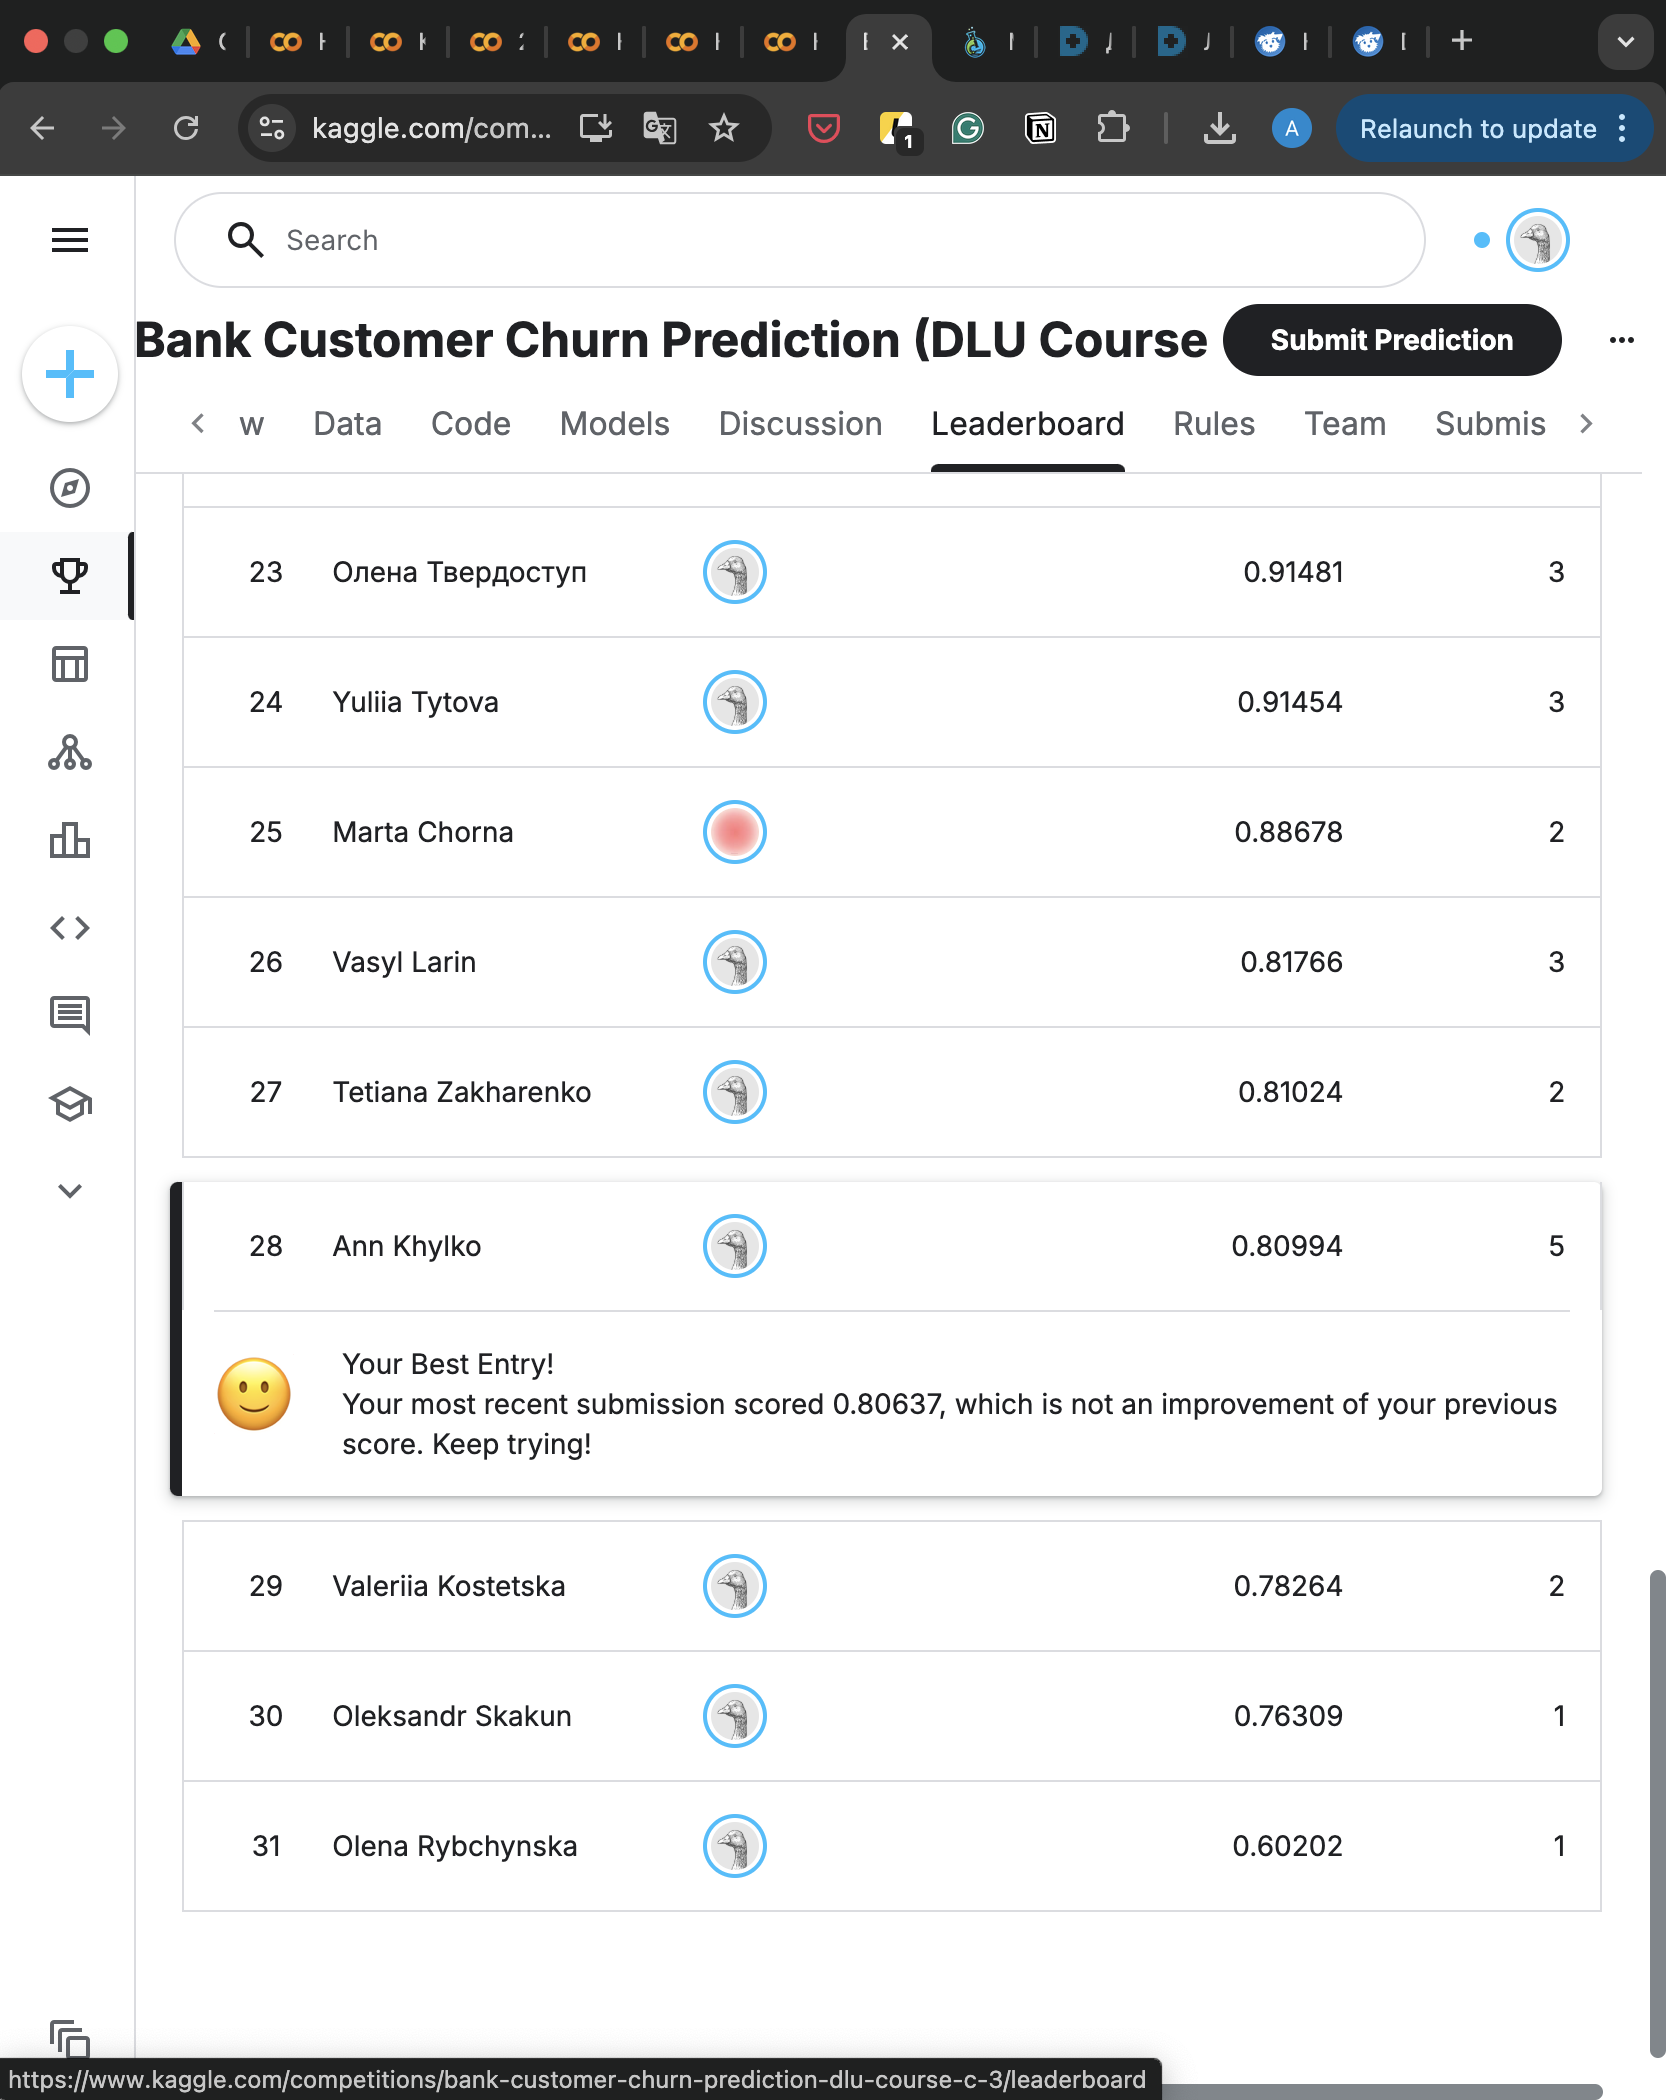